There are several goals for this project:

*   Be able to identify and outline crops within our ROI based on the USDA/NASS/CDL dataset from Google Earth Engine
*   Calculate the NDVI, soil moisture**, and weather data for each crop taken from above
*   Predict the crop yield using the NDVI value of each plot of land


**Soil moisture data currently not included in model.



# Data

In [4]:
import ee
from google.colab import drive
import datetime
import pandas as pd
import os

# @title Query data from Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-ndvi-change-detection')

# Define your Area of Interest (AOI) and the year of interest
aoi = ee.Geometry.Polygon([
    [-94.70937177214154, 41.15239644721922],
    [-93.93483563932904, 41.15239644721922],
    [-93.93483563932904, 41.42069426963426],
    [-94.70937177214154, 41.42069426963426],
    [-94.70937177214154, 41.15239644721922]
])

year = 2020

# Load the USDA/NASS/CDL dataset for the specified year and filter by the AOI
cdl = ee.Image(f'USDA/NASS/CDL/{year}').select('cropland').clip(aoi)

# Filter for corn areas
corn_areas = cdl.eq(1)

# Generate random points within the AOI
random_points = ee.FeatureCollection.randomPoints(region=aoi, points=100, seed=42)

# Correctly select a few random points for analysis
num_points_to_analyze = 5
selected_points = random_points.limit(num_points_to_analyze)

# Function to extract daily NDVI, temperature, precipitation, and soil moisture
def extract_daily_values(date_str):
    date = ee.Date(date_str)
    next_day = date.advance(1, 'day')

    # NDVI calculation
    ndvi = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
        .filterDate(date, next_day)\
        .filterBounds(aoi)\
        .select(['B8', 'B4'])\
        .mean()\
        .normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Soil moisture extraction
    soil_moisture = ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')\
        .filterDate(date, next_day)\
        .filterBounds(aoi)\
        .select('ssm')\
        .mean().rename('soil moisture')

    # Weather data extraction
    weather = ee.ImageCollection('ECMWF/ERA5/DAILY')\
        .filterDate(date, next_day)\
        .filterBounds(aoi)\
        .select(['mean_2m_air_temperature', 'total_precipitation'])\
        .mean().rename(['temperature', 'precipitation'])

    # Combine all bands
    combined = ndvi.addBands([soil_moisture, weather])

    # Sample the combined data at the selected points
    sampled = combined.sampleRegions(collection=selected_points, scale=30, geometries=True)

    # Export the sampled data
    task = ee.batch.Export.table.toDrive(
        collection=sampled,
        description='DailyCornData_' + date_str,
        folder='GEE_Exports',
        fileNamePrefix='daily_' + date_str,
        fileFormat='CSV'
    )

    task.start()

# Create a list of daily dates for January 2020
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 6, 30)
date_generated = [start_date + datetime.timedelta(days=x) for x in range((end_date-start_date).days + 1)]

# Iterate over the generated daily dates
for date_obj in date_generated:
    date_str = date_obj.strftime("%Y-%m-%d")
    extract_daily_values(date_str)


In [58]:
# @title Tracking task status for bigger jobs
tasks = ee.batch.Task.list()
print(tasks[0].status())

{'state': 'COMPLETED', 'description': 'DailyCornData_2020-06-30', 'creation_timestamp_ms': 1710105718255, 'update_timestamp_ms': 1710105827346, 'start_timestamp_ms': 1710105825367, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/#folders/1dTAcDKdNtrIgFp1T0JfGTf2lxAWqM6qT'], 'attempt': 1, 'batch_eecu_usage_seconds': 1.4205905199050903, 'id': 'C7OMTUIFOWO6KZKAXQGJINJ6', 'name': 'projects/ee-ndvi-change-detection/operations/C7OMTUIFOWO6KZKAXQGJINJ6'}


In [5]:
# @title Import the data
directory_path = '/content/drive/My Drive/GEE_Exports'

# List all files in the specified directory
all_files = os.listdir(directory_path)

# Initialize an empty DataFrame to hold the aggregated data
aggregated_df = pd.DataFrame()

for file_name in all_files:
    if file_name.endswith('.csv'):
        try:
            # Extract the base name without extension
            base_name = file_name.split('.')[0]
            # Assuming format "daily_YYYY-MM-DD" potentially followed by " (1)" or similar
            date_str = base_name.split('_')[1]
            # Remove any potential "(1)" or similar suffix and strip whitespace
            date_str = date_str.split(' ')[0].strip()
            # Convert date_str to a proper datetime format
            temp_df = pd.read_csv(os.path.join(directory_path, file_name))
            temp_df['Date'] = pd.to_datetime(date_str, format='%Y-%m-%d')
            aggregated_df = pd.concat([aggregated_df, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Ensure the 'Date' column is in datetime format (this may be redundant but is a safeguard)
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'])

print(aggregated_df.describe())

             NDVI  precipitation  temperature  soil_moisture  soil moisture
count  390.000000   3.900000e+02   390.000000      17.000000     112.000000
mean     0.161679   2.265860e-03   279.430544      25.056650      22.162321
std      0.218608   7.526828e-03    10.975255       0.160300       2.653283
min     -0.053852  -8.568168e-08   253.429200      24.744047      15.476805
25%      0.001828   2.270564e-06   271.058750      24.920902      20.789164
50%      0.057662   8.925982e-05   277.138100      25.023836      22.111557
75%      0.245554   7.154774e-04   287.833600      25.151611      24.856801
max      0.852849   7.002287e-02   301.615900      25.324497      25.377827


# Model

Location {"geodesic":false,"type":"Point","coordinates":[-94.41028633087356,41.316080115216536]} has insufficient data for training/testing split. Skipping.
Location {"geodesic":false,"type":"Point","coordinates":[-94.16289030162704,41.23981314759479]} has insufficient data for training/testing split. Skipping.
Location {"geodesic":false,"type":"Point","coordinates":[-94.26529824401668,41.17729040382007]} has insufficient data for training/testing split. Skipping.


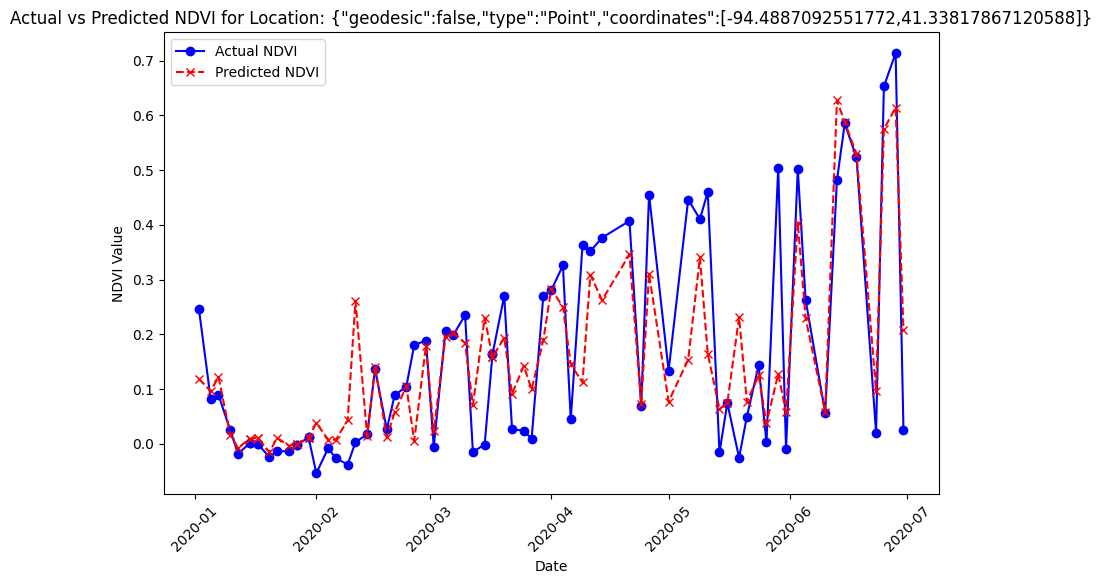

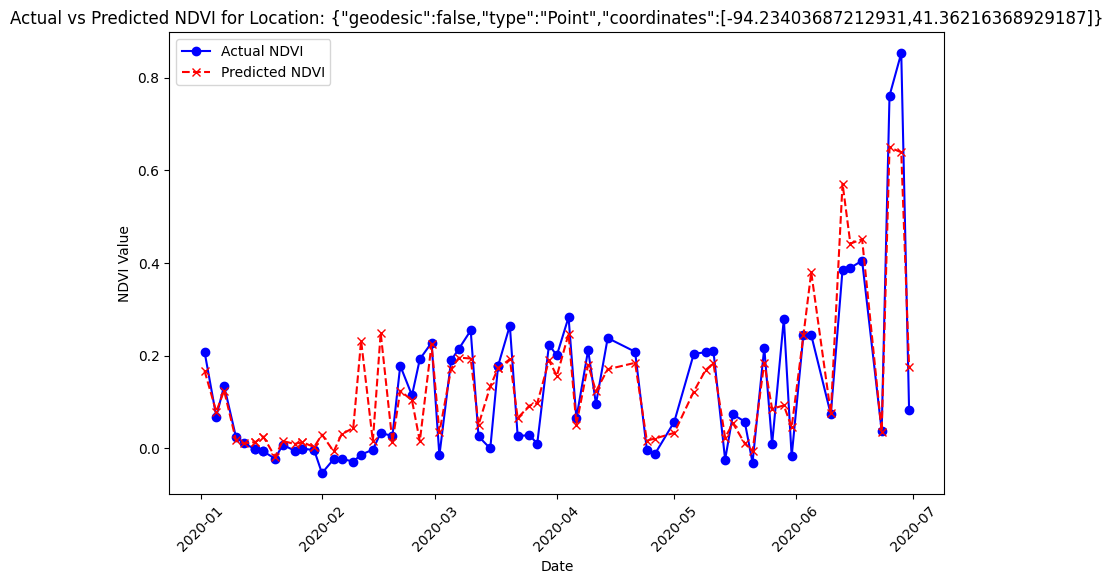

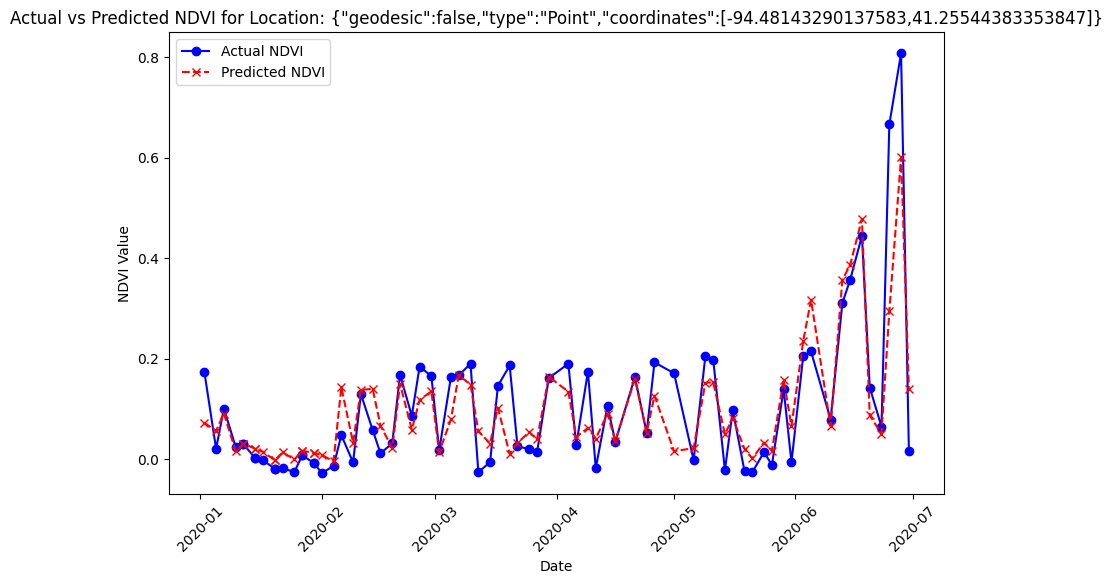

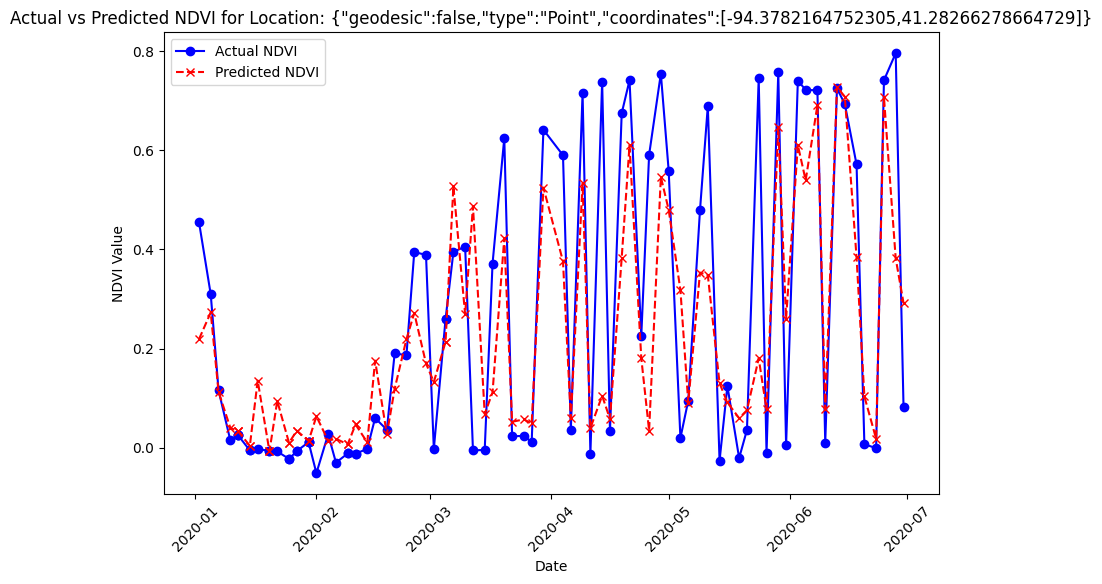

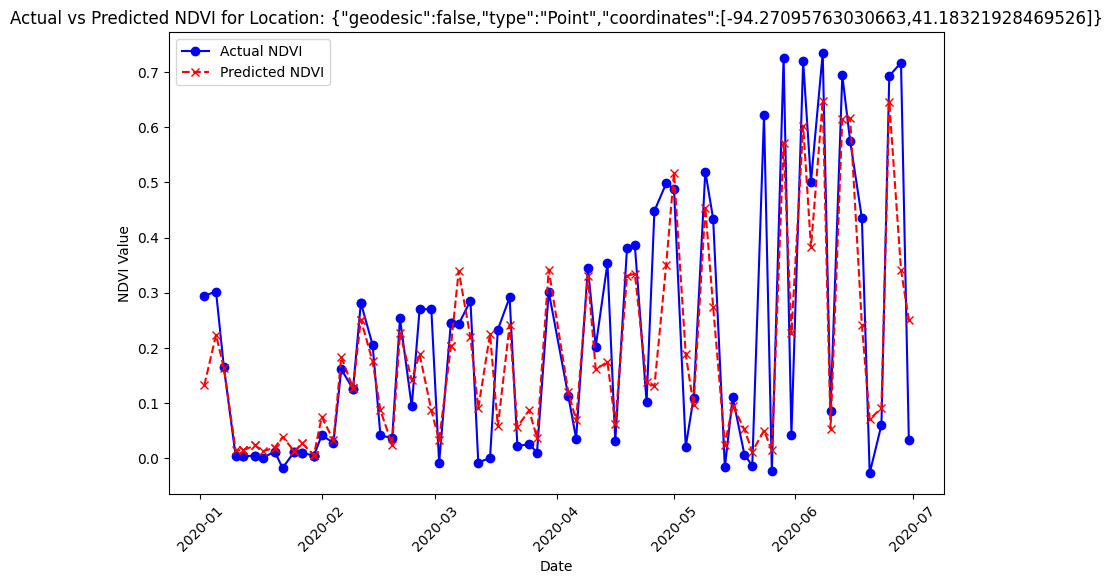

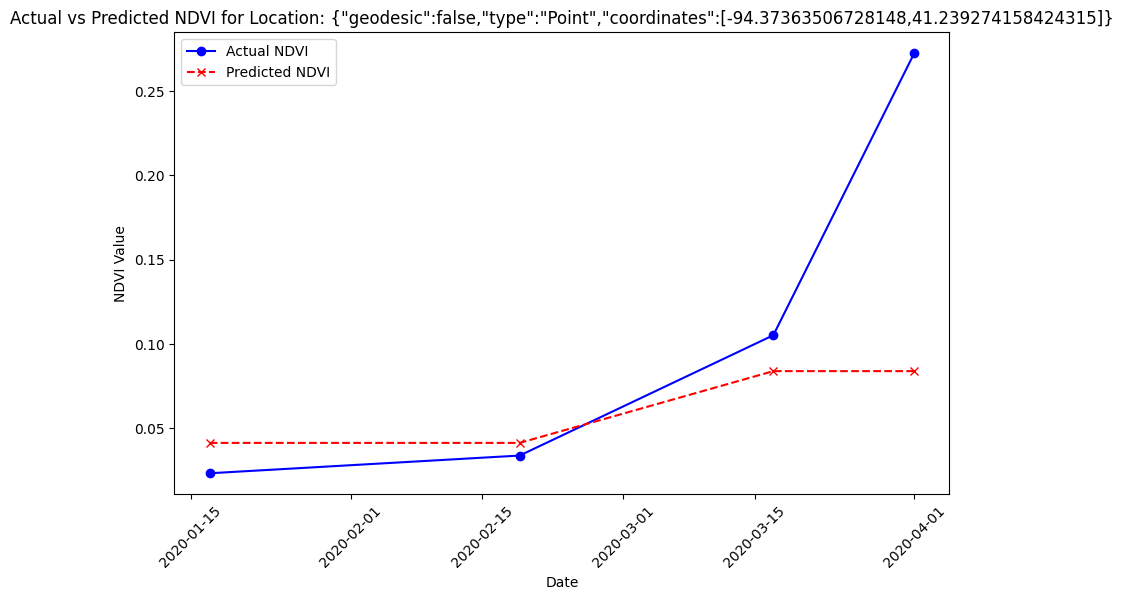

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

# @title Training the Random Forest Regression model (Soil moisture not included - in progress)
# Example using location_id as the identifier
location_ids = aggregated_df['.geo'].unique()  # Get unique location IDs

# To store RMSE values for locations with enough data for model evaluation
rmse_values = {}
locations_with_sufficient_data = []

for location_id in location_ids:
    df_location = aggregated_df[aggregated_df['.geo'] == location_id]

    X = df_location[['temperature', 'precipitation']]
    y = df_location['NDVI']

    if len(df_location) > 3:  # Minimal sample check
        # Proceed with training/testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Store the model
        models[location_id] = model

        # Generate predictions for the entire dataset to visualize
        predicted_ndvi = model.predict(X)

        # Calculate RMSE for evaluation
        predictions_test = model.predict(X_test)

        # Assign predictions to the DataFrame
        aggregated_df.loc[aggregated_df['.geo'] == location_id, 'Predicted_NDVI'] = predicted_ndvi

        locations_with_sufficient_data.append(location_id)
    else:
        print(f"Location {location_id} has insufficient data for training/testing split. Skipping.")



# Step 3: Visualization
for location_id in locations_with_sufficient_data:
    df_plot = aggregated_df[aggregated_df['.geo'] == location_id].sort_values('Date')

    plt.figure(figsize=(10, 6))
    plt.plot(df_plot['Date'], df_plot['NDVI'], label='Actual NDVI', color='blue', marker='o')
    plt.plot(df_plot['Date'], df_plot['Predicted_NDVI'], label='Predicted NDVI', color='red', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted NDVI for Location: {location_id}')
    plt.xlabel('Date')
    plt.ylabel('NDVI Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [37]:
import numpy as np
# @title Performance metrics (Need to be reviewed)

# Convert the dictionary to a DataFrame for easier analysis
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Location_ID'}, inplace=True)

print(metrics_df)

                                         Location_ID     RMSE       MAE  \
0  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   
1  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   
2  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   
3  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   
4  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   
5  {"geodesic":false,"type":"Point","coordinates"...  0.13342  0.098023   

   R-squared  
0  -0.250615  
1  -0.250615  
2  -0.250615  
3  -0.250615  
4  -0.250615  
5  -0.250615  


# Visualizations

In [55]:
import json
def extract_lat_lon(geojson_str):
    geojson = json.loads(geojson_str)
    if geojson['type'] == 'Point':
        # Extract latitude and longitude for Point geometry
        lon, lat = geojson['coordinates']
        return lat, lon
    # Add more conditions if working with other types (e.g., Polygon)
    return None, None  # Return None if geometry is not a Point

# Apply the function to each row in the DataFrame
aggregated_df[['latitude', 'longitude']] = aggregated_df.apply(
    lambda row: pd.Series(extract_lat_lon(row['.geo'])), axis=1)

# Creating a map centered around the average latitude and longitude
map_center = [aggregated_df['latitude'].mean(), aggregated_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Adding points for each spot in aggregated_df
for _, row in aggregated_df.iterrows():
    # Define popup content
    popup_content = f"""
    <table style='width:200px'>
        <tr>
            <th style='text-align:left;'><strong>Location</strong></th>
            <td>{row['latitude']:.4f}, {row['longitude']:.4f}</td>
        </tr>
        <tr>
            <th style='text-align:left;'><strong>Actual NDVI</strong></th>
            <td>{row['NDVI']:.2f}</td>
        </tr>
        <tr>
            <th style='text-align:left;'><strong>Predicted NDVI</strong></th>
            <td>{row['Predicted_NDVI']:.2f}</td>
        </tr>
    </table>
    """
    popup = folium.Popup(popup_content, max_width=250)

    # Create CircleMarker
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['NDVI'] >= row['Predicted_NDVI'] else 'red',
        fill=True,
        fill_color='blue' if row['NDVI'] >= row['Predicted_NDVI'] else 'red',
        fill_opacity=0.7,
        popup=popup,
    ).add_to(m)

# Display the map
m